In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from projects.ephys.population import Population
from src.utils.path import find
from src.utils.auxiliary import flatten_series
from scipy.interpolate import interp1d
import json
from src.utils.path import auto_recording_name
from scipy.signal import butter, sosfiltfilt
import gc
from tqdm import tqdm

In [2]:
hffm_savepath = '/home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_031822')

reading from /home/niell_lab/data/freely_moving_ephys/batch_files/021022/hffm/hffm_031822.pickle


In [3]:
mpl.rcParams.update({'font.size': 13})
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# Using defs based on deye vs dhead

In [ ]:
row = hffm.data.iloc[175]

plt.subplots(2,2,figsize=(10,6))

plt.subplot(221)
plt.plot(hffm.trange_x, row['FmLt_rightsacc_avg_gaze_shift_dEye'], color='tab:blue', label='right')
plt.plot(hffm.trange_x, row['FmLt_leftsacc_avg_gaze_shift_dEye'], color='tab:orange', label='left')
plt.legend()
plt.xlim([-0.2,0.5])
plt.ylim([0,np.max([np.max(row['FmLt_rightsacc_avg_gaze_shift_dEye']), np.max(row['FmLt_leftsacc_avg_gaze_shift_dEye'])])*1.2])
plt.title('dEye gaze shift')

plt.subplot(222)
plt.plot(hffm.trange_x, row['FmLt_rightsacc_avg_comp_dEye'], color='tab:blue', label='right')
plt.plot(hffm.trange_x, row['FmLt_leftsacc_avg_comp_dEye'], color='tab:orange', label='left')
plt.legend()
plt.xlim([-0.2,0.5])
plt.ylim([0,np.max([np.max(row['FmLt_rightsacc_avg_comp_dEye']), np.max(row['FmLt_leftsacc_avg_comp_dEye'])])*1.2])
plt.title('dEye comp.')

plt.subplot(223)
plt.plot(hffm.trange_x, row['FmLt_rightsacc_avg_gaze_shift_dHead'], color='tab:blue', label='right')
plt.plot(hffm.trange_x, row['FmLt_leftsacc_avg_gaze_shift_dHead'], color='tab:orange', label='left')
plt.legend()
plt.xlim([-0.2,0.5])
plt.ylim([0,np.max([np.max(row['FmLt_rightsacc_avg_gaze_shift_dHead']), np.max(row['FmLt_leftsacc_avg_gaze_shift_dHead'])])*1.2])
plt.title('dHead gaze shift')

plt.subplot(224)
plt.plot(hffm.trange_x, row['FmLt_rightsacc_avg_comp_dHead'], color='tab:blue', label='right')
plt.plot(hffm.trange_x, row['FmLt_leftsacc_avg_comp_dHead'], color='tab:orange', label='left')
plt.legend()
plt.xlim([-0.2,0.5])
plt.ylim([0,np.max([np.max(row['FmLt_rightsacc_avg_comp_dHead']), np.max(row['FmLt_leftsacc_avg_comp_dHead'])])*1.2])
plt.title('dHead comp.')

plt.tight_layout()

In [ ]:
trange = hffm.trange.copy()
def calc_psth(spikeT, eventT):
    psth = np.zeros(trange.size-1)
    for s in np.array(eventT):
        hist, _ = np.histogram(spikeT-s, trange)
        psth = psth + hist / (eventT.size*np.diff(trange))
    return psth

def try_saccthresh(row, comp, gazeshift, win=0.25):
    bad_comp = np.array([c for c in comp for g in gazeshift if ((g>(c-win)) & (g<=c))])
    clean_comp = np.delete(comp, np.isin(comp, bad_comp))
    lowth_comp = calc_psth(row['FmLt_spikeT'], comp) # PSTH if you use the different threshold
    nogs_comp = calc_psth(row['FmLt_spikeT'], clean_comp) # PSTH is you remove comp. movements that happened right after a gaze shift
    return lowth_comp, nogs_comp 

In [ ]:
row = hffm.data.iloc[211]

In [ ]:
high_sacc_thresh = 5/.016 # deg/sec
low_sacc_thresh = 3/.016 # deg/sec
gaze_sacc_thresh = 0.6/.016 # deg/sec
# gaze-shift
left_gazeshift = row['FmLt_eyeT'][(np.append(row['FmLt_dHead'], 0) > low_sacc_thresh) & (np.append(row['FmLt_dGaze'],0) > low_sacc_thresh)]
right_gazeshift = row['FmLt_eyeT'][(np.append(row['FmLt_dHead'], 0) < -low_sacc_thresh) & (np.append(row['FmLt_dGaze'], 0) < -low_sacc_thresh)]
# comp
left_comp = row['FmLt_eyeT'][(np.append(row['FmLt_dHead'], 0) > low_sacc_thresh) & (np.append(row['FmLt_dGaze'], 0) < gaze_sacc_thresh)]
right_comp = row['FmLt_eyeT'][(np.append(row['FmLt_dHead'], 0) < -low_sacc_thresh) & (np.append(row['FmLt_dGaze'], 0) > -gaze_sacc_thresh)]

lowth_left, nogs_left = try_saccthresh(row, left_comp, left_gazeshift)
lowth_right, nogs_right = try_saccthresh(row, right_comp, right_gazeshift)

In [ ]:
left_gazeshift_dE = row['FmLt_eyeT'][(np.append(row['FmLt_dEye_dps'], 0) > high_sacc_thresh) & (np.append(row['FmLt_dGaze'],0) > high_sacc_thresh)]
right_gazeshift_dE = row['FmLt_eyeT'][(np.append(row['FmLt_dEye_dps'], 0) < -high_sacc_thresh) & (np.append(row['FmLt_dGaze'], 0) < -high_sacc_thresh)]

left_comp_dE = row['FmLt_eyeT'][(np.append(row['FmLt_dEye_dps'], 0) > low_sacc_thresh) & (np.append(row['FmLt_dGaze'], 0) < gaze_sacc_thresh)]
right_comp_dE = row['FmLt_eyeT'][(np.append(row['FmLt_dEye_dps'], 0) < -low_sacc_thresh) & (np.append(row['FmLt_dGaze'], 0) > -gaze_sacc_thresh)]

lowth_left_dE, nogs_left_dE = try_saccthresh(row, left_comp_dE, left_gazeshift_dE)
lowth_right_dE, nogs_right_dE = try_saccthresh(row, right_comp_dE, right_gazeshift_dE)

In [ ]:
plt.subplots(2,3,figsize=(15,6))

plt.subplot(231)
plt.plot(hffm.trange_x, row['FmLt_rightsacc_avg_gaze_shift_dEye'], color='tab:blue', label='right')
plt.plot(hffm.trange_x, row['FmLt_leftsacc_avg_gaze_shift_dEye'], color='tab:orange', label='left')
plt.legend()
plt.xlim([-0.2,0.5])
plt.ylim([0,np.max([np.max(row['FmLt_rightsacc_avg_gaze_shift_dEye']), np.max(row['FmLt_leftsacc_avg_gaze_shift_dEye'])])*1.2])
plt.title('dEye gaze shift')

plt.subplot(232)
plt.plot(hffm.trange_x, row['FmLt_rightsacc_avg_comp_dEye'], color='tab:blue', label='right')
plt.plot(hffm.trange_x, row['FmLt_leftsacc_avg_comp_dEye'], color='tab:orange', label='left')
plt.xlim([-0.2,0.5])
plt.ylim([0,np.max([np.max(row['FmLt_rightsacc_avg_comp_dEye']), np.max(row['FmLt_leftsacc_avg_comp_dEye'])])*1.2])
plt.title('dEye comp.')

plt.subplot(233)
plt.plot(hffm.trange_x, nogs_right_dE, color='tab:blue', label='right')
plt.plot(hffm.trange_x, nogs_left_dE, color='tab:orange', label='left')
plt.xlim([-0.2,0.5])
plt.ylim([0,np.max([np.max(nogs_right_dE), np.max(nogs_left_dE)])*1.2])
plt.title('comp. w/out gaze shift (prev. 250msec)')

plt.subplot(234)
plt.plot(hffm.trange_x, row['FmLt_rightsacc_avg_gaze_shift_dHead'], color='tab:blue', label='right')
plt.plot(hffm.trange_x, row['FmLt_leftsacc_avg_gaze_shift_dHead'], color='tab:orange', label='left')
plt.xlim([-0.2,0.5])
plt.ylim([0,np.max([np.max(row['FmLt_rightsacc_avg_gaze_shift_dHead']), np.max(row['FmLt_leftsacc_avg_gaze_shift_dHead'])])*1.2])
plt.title('dHead gaze shift')

plt.subplot(235)
plt.plot(hffm.trange_x, row['FmLt_rightsacc_avg_comp_dHead'], color='tab:blue', label='right')
plt.plot(hffm.trange_x, row['FmLt_leftsacc_avg_comp_dHead'], color='tab:orange', label='left')
plt.xlim([-0.2,0.5])
plt.ylim([0,np.max([np.max(row['FmLt_rightsacc_avg_comp_dHead']), np.max(row['FmLt_leftsacc_avg_comp_dHead'])])*1.2])
plt.title('dHead comp.')

plt.subplot(236)
plt.plot(hffm.trange_x, nogs_right, color='tab:blue', label='right')
plt.plot(hffm.trange_x, nogs_left, color='tab:orange', label='left')
plt.xlim([-0.2,0.5])
plt.ylim([0,np.max([np.max(nogs_right), np.max(nogs_left)])*1.2])
plt.title('comp. w/out gaze shift (prev. 250msec)')

plt.tight_layout()

# Saccade CSD

In [ ]:
rec = hffm.data[hffm.data['session']=='070921_J553RT_control_Rig2'].copy()
# recpath = os.path.join(rec['original_session_path'].iloc[0], 'fm1')
# recording_name = auto_recording_name(recpath)
num_channels = 128
probe_name = 'DB_P128-6'
# ephys_bin_path = os.path.join(recpath, recording_name + '_Ephys.bin')
ephys_bin_path = '/home/niell_lab/Desktop/lfp_tests/070921_J553RT_control_Rig2_fm1_Ephys.bin'

In [ ]:
def read_binary_file(ephys_bin_path, probe_name, num_channels, do_remap=True):
    channel_map_path = '/home/niell_lab/Documents/github/FreelyMovingEphys/config/channel_maps.json'
    # set up data types to read binary file into
    dtypes = np.dtype([('ch'+str(i),np.uint16) for i in range(0,num_channels)])
    # read in binary file
    ephys = pd.DataFrame(np.fromfile(ephys_bin_path, dtypes, -1, ''))
    if do_remap:
        # open channel map file
        with open(channel_map_path, 'r') as fp:
            all_maps = json.load(fp)
        # get channel map for the current probe
        ch_map = all_maps[probe_name]
        # remap with known order of channels
        ephys = ephys.iloc[:,[i-1 for i in list(ch_map)]]
    return ephys

def butter_bandpass(lfp, lowcut=1, highcut=300, fs=30000, order=5):
    nyq = 0.5 * fs # Nyquist frequency
    low = lowcut / nyq # low cutoff
    high = highcut / nyq # high cutoff
    sos = butter(order, [low, high], btype='bandpass', output='sos')
    filt = sosfiltfilt(sos, lfp, axis=0)
    return filt

In [ ]:
# read in the binary file of ephys recording
lfp_ephys = read_binary_file(ephys_bin_path, probe_name, num_channels).to_numpy()

In [ ]:
# subtract off average for each channel, then apply bandpass filter
lfp_ephys = lfp_ephys - np.mean(lfp_ephys, 0)

In [ ]:
for ch in tqdm(range(np.size(lfp_ephys, 1))):
    lfp_ephys[:,ch] = butter_bandpass(lfp_ephys[:,ch], order=6)

In [ ]:
high_sacc_thresh = 5/.016 # deg/sec
low_sacc_thresh = 3/.016 # deg/sec
gaze_sacc_thresh = 0.6/.016 # deg/sec

In [ ]:
eyeT = rec['FmLt_eyeT'].iloc[0].copy()
row = rec.iloc[0].copy()
# times when there was a gaze-shifting saccade (in terms of eyeT)
left_gazeshift = row['FmLt_eyeT'][(np.append(row['FmLt_dEye_dps'], 0) > high_sacc_thresh) & (np.append(row['FmLt_dGaze'],0) > high_sacc_thresh)]
right_gazeshift = row['FmLt_eyeT'][(np.append(row['FmLt_dEye_dps'], 0) < -high_sacc_thresh) & (np.append(row['FmLt_dGaze'], 0) < -high_sacc_thresh)]
left_comp = row['FmLt_eyeT'][(np.append(row['FmLt_dEye_dps'], 0) > low_sacc_thresh) & (np.append(row['FmLt_dGaze'], 0) < gaze_sacc_thresh)]
right_comp = row['FmLt_eyeT'][(np.append(row['FmLt_dEye_dps'], 0) < -low_sacc_thresh) & (np.append(row['FmLt_dGaze'], 0) > -gaze_sacc_thresh)]

In [ ]:
sacc = left_gazeshift.copy()

In [ ]:
win_start = -0.2
win_end = 0.4
ephys_samprate = 30000

# sacc = sacc[sacc>0] # remove saccades w/ negative timestamp
sacc = sacc[sacc<(np.max(eyeT)-win_end)] # remove saccades that happen too close to the end of the recording to have a full LFP window

# get response of each channel centered around time of checkerboard reversal
all_resp = np.zeros([np.size(lfp_ephys, 1),
                     np.size(sacc),
                     len(list(set(np.arange(1+win_start, 1+win_end, 1/ephys_samprate))))])

for ind, saccT in tqdm(enumerate(sacc)):
    saccInd = int(np.argwhere(eyeT==saccT))
    for ch_num in range(np.size(lfp_ephys, 1)):
        # index of ephys data to start window with, aligned to set time before saccade
        bin_start = int((eyeT[saccInd]+win_start)*ephys_samprate)
        # index of ephys data to end window with, aligned to time after saccade
        bin_end = int((eyeT[saccInd]+win_end)*ephys_samprate)
        # index into the filtered ephys data and store each trace for this channel of the probe
        if bin_end < np.size(lfp_ephys, 0): # make sure it's a possible range
            all_resp[ch_num, ind] = lfp_ephys[bin_start:bin_end, ch_num]
# mean of responses within each channel
rev_resp_mean = np.mean(all_resp, 1)

In [ ]:
# # plot traces for shanks
# if self.num_channels==64:
#     colors = plt.cm.jet(np.linspace(0,1,32))
#     plt.subplots(1, 2, figsize=(8,6))
#     for ch_num in np.arange(0,64):
#         if ch_num<=31:
#             plt.subplot(1,2,1)
#             plt.plot(rev_resp_mean[ch_num], color=colors[ch_num], linewidth=1)
#             plt.title('shank0'); plt.axvline(x=(0.1*self.ephys_samprate))
#             plt.xticks(np.arange(0,18000,18000/5), np.arange(0,600,600/5))
#         if ch_num>31:
#             plt.subplot(1,2,2)
#             plt.plot(rev_resp_mean[ch_num], color=colors[ch_num-32], linewidth=1)
#             plt.title('shank1'); plt.axvline(x=(0.1*self.ephys_samprate))
#             plt.xticks(np.arange(0,18000,18000/5), np.arange(0,600,600/5))
#     plt.tight_layout()
#     self.detail_pdf.savefig(); plt.close()
#     num_cols_to_plot = 2

# elif self.num_channels==16:
#     colors = plt.cm.jet(np.linspace(0,1,16))
#     plt.figure()
#     for ch_num in np.arange(0,16):
#         plt.plot(rev_resp_mean[ch_num], color=colors[ch_num], linewidth=1)
#         plt.axvline(x=(0.1*self.ephys_samprate))
#         plt.xticks(np.arange(0,18000,18000/5), np.arange(0,600,600/5))
#     self.detail_pdf.savefig(); plt.close()
#     num_cols_to_plot = 1

# elif self.num_channels==128:
#     colors = plt.cm.jet(np.linspace(0,1,32))
#     plt.subplots(1,4 ,figsize=(40,6))
#     for ch_num in np.arange(0,128):
#         if ch_num < 32:
#             plt.subplot(1,4,1)
#             plt.plot(rev_resp_mean[ch_num], color=colors[ch_num], linewidth=1)
#             plt.title('shank0'); plt.axvline(x=(0.1*self.ephys_samprate))
#             plt.xticks(np.arange(0,18000,18000/5), np.arange(0,600,600/5))
#         elif 32 <= ch_num < 64:
#             plt.subplot(1,4,2)
#             plt.plot(rev_resp_mean[ch_num], color=colors[ch_num-32], linewidth=1)
#             plt.title('shank1'); plt.axvline(x=(0.1*self.ephys_samprate))
#             plt.xticks(np.arange(0,18000,18000/5), np.arange(0,600,600/5))
#         elif 64 <= ch_num < 96:
#             plt.subplot(1,4,3)
#             plt.plot(rev_resp_mean[ch_num], color=colors[ch_num-64], linewidth=1)
#             plt.title('shank2'); plt.axvline(x=(0.1*self.ephys_samprate))
#             plt.xticks(np.arange(0,18000,18000/5), np.arange(0,600,600/5))
#         elif 96 <= ch_num < 128:
#             plt.subplot(1,4,4)
#             plt.plot(rev_resp_mean[ch_num], color=colors[ch_num-96], linewidth=1)
#             plt.title('shank3'); plt.axvline(x=(0.1*self.ephys_samprate))
#             plt.xticks(np.arange(0,18000,18000/5), np.arange(0,600,600/5))
#     plt.tight_layout()
#     self.detail_pdf.savefig(); plt.close()
#     num_cols_to_plot = 4

In [ ]:
np.max(rev_resp_mean)

In [ ]:
num_cols_to_plot = 4
fig, axes = plt.subplots(int(np.size(rev_resp_mean,0)/num_cols_to_plot), num_cols_to_plot, figsize=(7,30), sharey=True)
for ch_num, ax in enumerate(axes.T.flatten()):
    ax.plot(rev_resp_mean[ch_num], linewidth=1)
    ax.set_ylim([-190,100])
#     ax.axvline(x=(0.1*ephys_samprate), linewidth=1)
    ax.axis('off')
    ax.set_title(ch_num)
plt.tight_layout()

In [ ]:
site_order = []
for sh in range(0,4):
    site_order += list(np.arange(0,128,4)+sh)

In [ ]:
site_order = list(np.arange(0,32))

In [ ]:
def calc_CSD(mean_resp, csd_interval=2, interp=True, exclude_ch=[]):
    if exclude_ch:
        for ch in exclude_ch:
            mean_resp[ch,:] = np.zeros(np.size(mean_resp,1))*np.nan
    mean_resp = mean_resp[~np.isnan(mean_resp).any(axis=1)]
    csd = np.ones([np.size(mean_resp,0), np.size(mean_resp,1)])
    for ch in range(2, np.size(mean_resp,0)-csd_interval):
        csd[ch] = mean_resp[ch] - 0.5*(mean_resp[ch-csd_interval] + mean_resp[ch+csd_interval])
    if interp:
        csd_interp = np.interp(csd, (csd.min(), csd.max()), (-1, +1)) # csd between -1 and 1
        return csd_interp
    else:
        return csd

In [ ]:
mean_resp = rev_resp_mean[layout[3],:].copy()

csd = calc_CSD(mean_resp, interp=False, exclude_ch=[6,23])
# for ch in range(32):
#     if (np.max(csd[ch,:]) > 100) or (np.min(csd[ch,:]) < -100):
#         csd[ch,:] = np.nan
plt.imshow(csd, cmap='jet', aspect='auto')
plt.title('shank 3')
plt.colorbar()

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(12,6))
spec = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

ax_depth = fig.add_subplot(spec[:,0])
ax_sh0 = fig.add_subplot(spec[0,1])
ax_sh1 = fig.add_subplot(spec[0,2])
ax_sh2 = fig.add_subplot(spec[1,1])
ax_sh3 = fig.add_subplot(spec[1,2])

# mua_power = row['Wn_lfp_power']
# layer5 = row['Wn_layer5cent_from_lfp']
# ch_spacing = 25
# for sh in range(4):
#     ax_depth.plot(mua_power[sh], np.arange(0,32)-layer5[sh], 'tab:red')
# ax_depth.hlines(0,np.min(mua_power),np.max(mua_power), 'k', linestyle='dashed')
# ax_depth.set_ylim([18,-19])
# ax_depth.set_yticks(ticks=np.arange(18,-19,-3), labels=(ch_spacing*np.arange(18,-19,-3)))
# ax_depth.set_ylabel('depth (um)')
# ax_depth.set_xlabel('LFP MUA power')
# ax_depth.annotate('layer 5', xy=[0.75, -.5], color='k', fontsize=12)
layout = np.stack([np.arange(0,32),np.arange(32,64),np.arange(64,96),np.arange(96,128)])
for sh_num, panel in enumerate([ax_sh0,ax_sh1,ax_sh2,ax_sh3]):
#     site_order = list(np.arange(0,128,4)+sh_num)
    site_order = layout[sh_num]
    mean_resp = rev_resp_mean[site_order,:]
    exclude = [[],[],[],[]]
#     exclude = [[],[],[15],[6,23]]
    csd = calc_CSD(mean_resp, exclude_ch=exclude[sh_num], interp=False)
    csd_img = panel.imshow(csd, cmap='jet', aspect='auto')
    plt.colorbar(csd_img, ax=panel)
    panel.set_xticks(np.linspace(0,18000,6), labels=np.linspace(win_start,win_end,6).round(1))
    panel.set_ylabel('channel')
    panel.set_xlabel('sec')
    panel.set_title('shank {}'.format(sh_num+1))
    panel.plot([7200,7200], [0,31], color='k', linewidth=3, linestyle='dotted')

In [ ]:
csd.shape

# baseline firing rate vs. saccade response

In [61]:
def to_color(r,g,b):
    return (r/255, g/255, b/255)
hffm.cmap_movclusts = {
    'all': 'k',
    'movement': to_color(230,135,45), # orange
    'early': to_color(44,140,109), # green
    'late': to_color(46,131,232), # blue
    'biphasic': to_color(222,190,43), # yellow
    'negative': to_color(111,61,175), # purple
    'unresponsive': 'dimgray',
}

In [ ]:
for i, c in enumerate(['motor','early','late','biphasic','negative','unresponsive']):
    active = hffm.data['FmLt_active_fr'][hffm.data['movcluster1']==c]
    inactive = hffm.data['FmLt_inactive_fr'][hffm.data['movcluster1']==c]
    plt.plot(active, inactive, '.', color=hffm.cmap_movclusts[c], label=c)
plt.legend()

# RFs by cluster

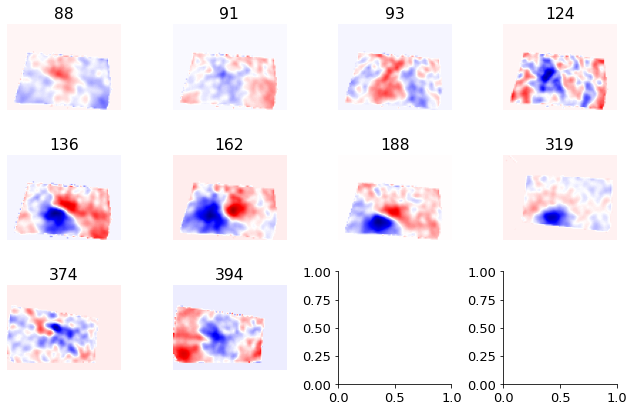

In [47]:
inds = hffm.data[hffm.data['movcluster1']=='movement'][hffm.data['has_rf']==True].index.values
cdim = 3
dim = int(np.ceil(len(inds)/cdim))
plt.subplots(cdim,dim,figsize=(9,6))
for i, ind in enumerate(inds):
    plt.subplot(cdim,dim,i+1)
    sta = hffm.data.loc[ind,'Wn_spike_triggered_average']
    sta_range = np.max(np.abs(sta))*1.2
    sta_range = (0.25 if sta_range<0.25 else sta_range)
    plt.imshow(sta, vmin=-sta_range, vmax=sta_range, cmap='seismic')
    plt.axis('off'); plt.title(ind)
plt.tight_layout()

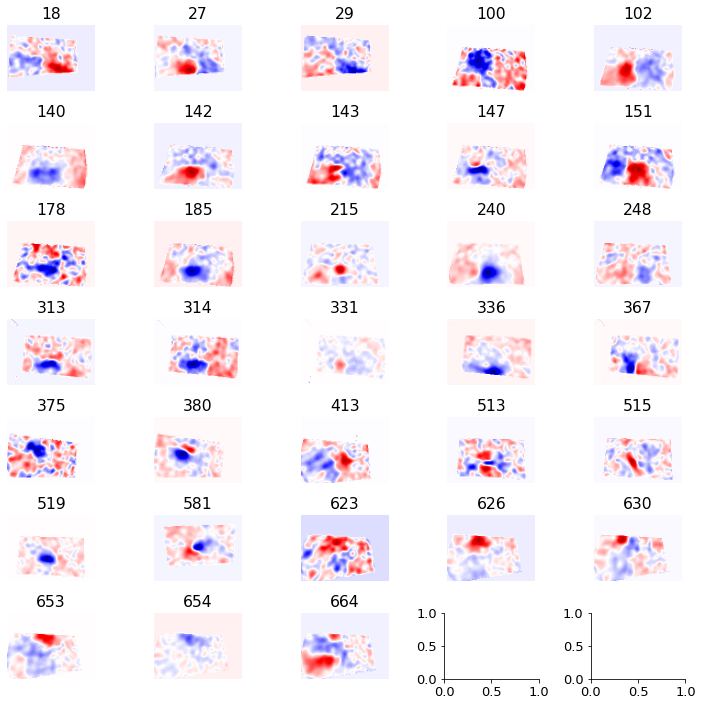

In [51]:
inds = hffm.data[hffm.data['movcluster1']=='early'][hffm.data['has_rf']==True].index.values
cdim = 7
dim = int(np.ceil(len(inds)/cdim))
plt.subplots(cdim,dim,figsize=(10,10))
for i, ind in enumerate(inds):
    plt.subplot(cdim,dim,i+1)
    sta = hffm.data.loc[ind,'Wn_spike_triggered_average']
    sta_range = np.max(np.abs(sta))*1.2
    sta_range = (0.25 if sta_range<0.25 else sta_range)
    plt.imshow(sta, vmin=-sta_range, vmax=sta_range, cmap='seismic')
    plt.axis('off'); plt.title(ind)
plt.tight_layout()

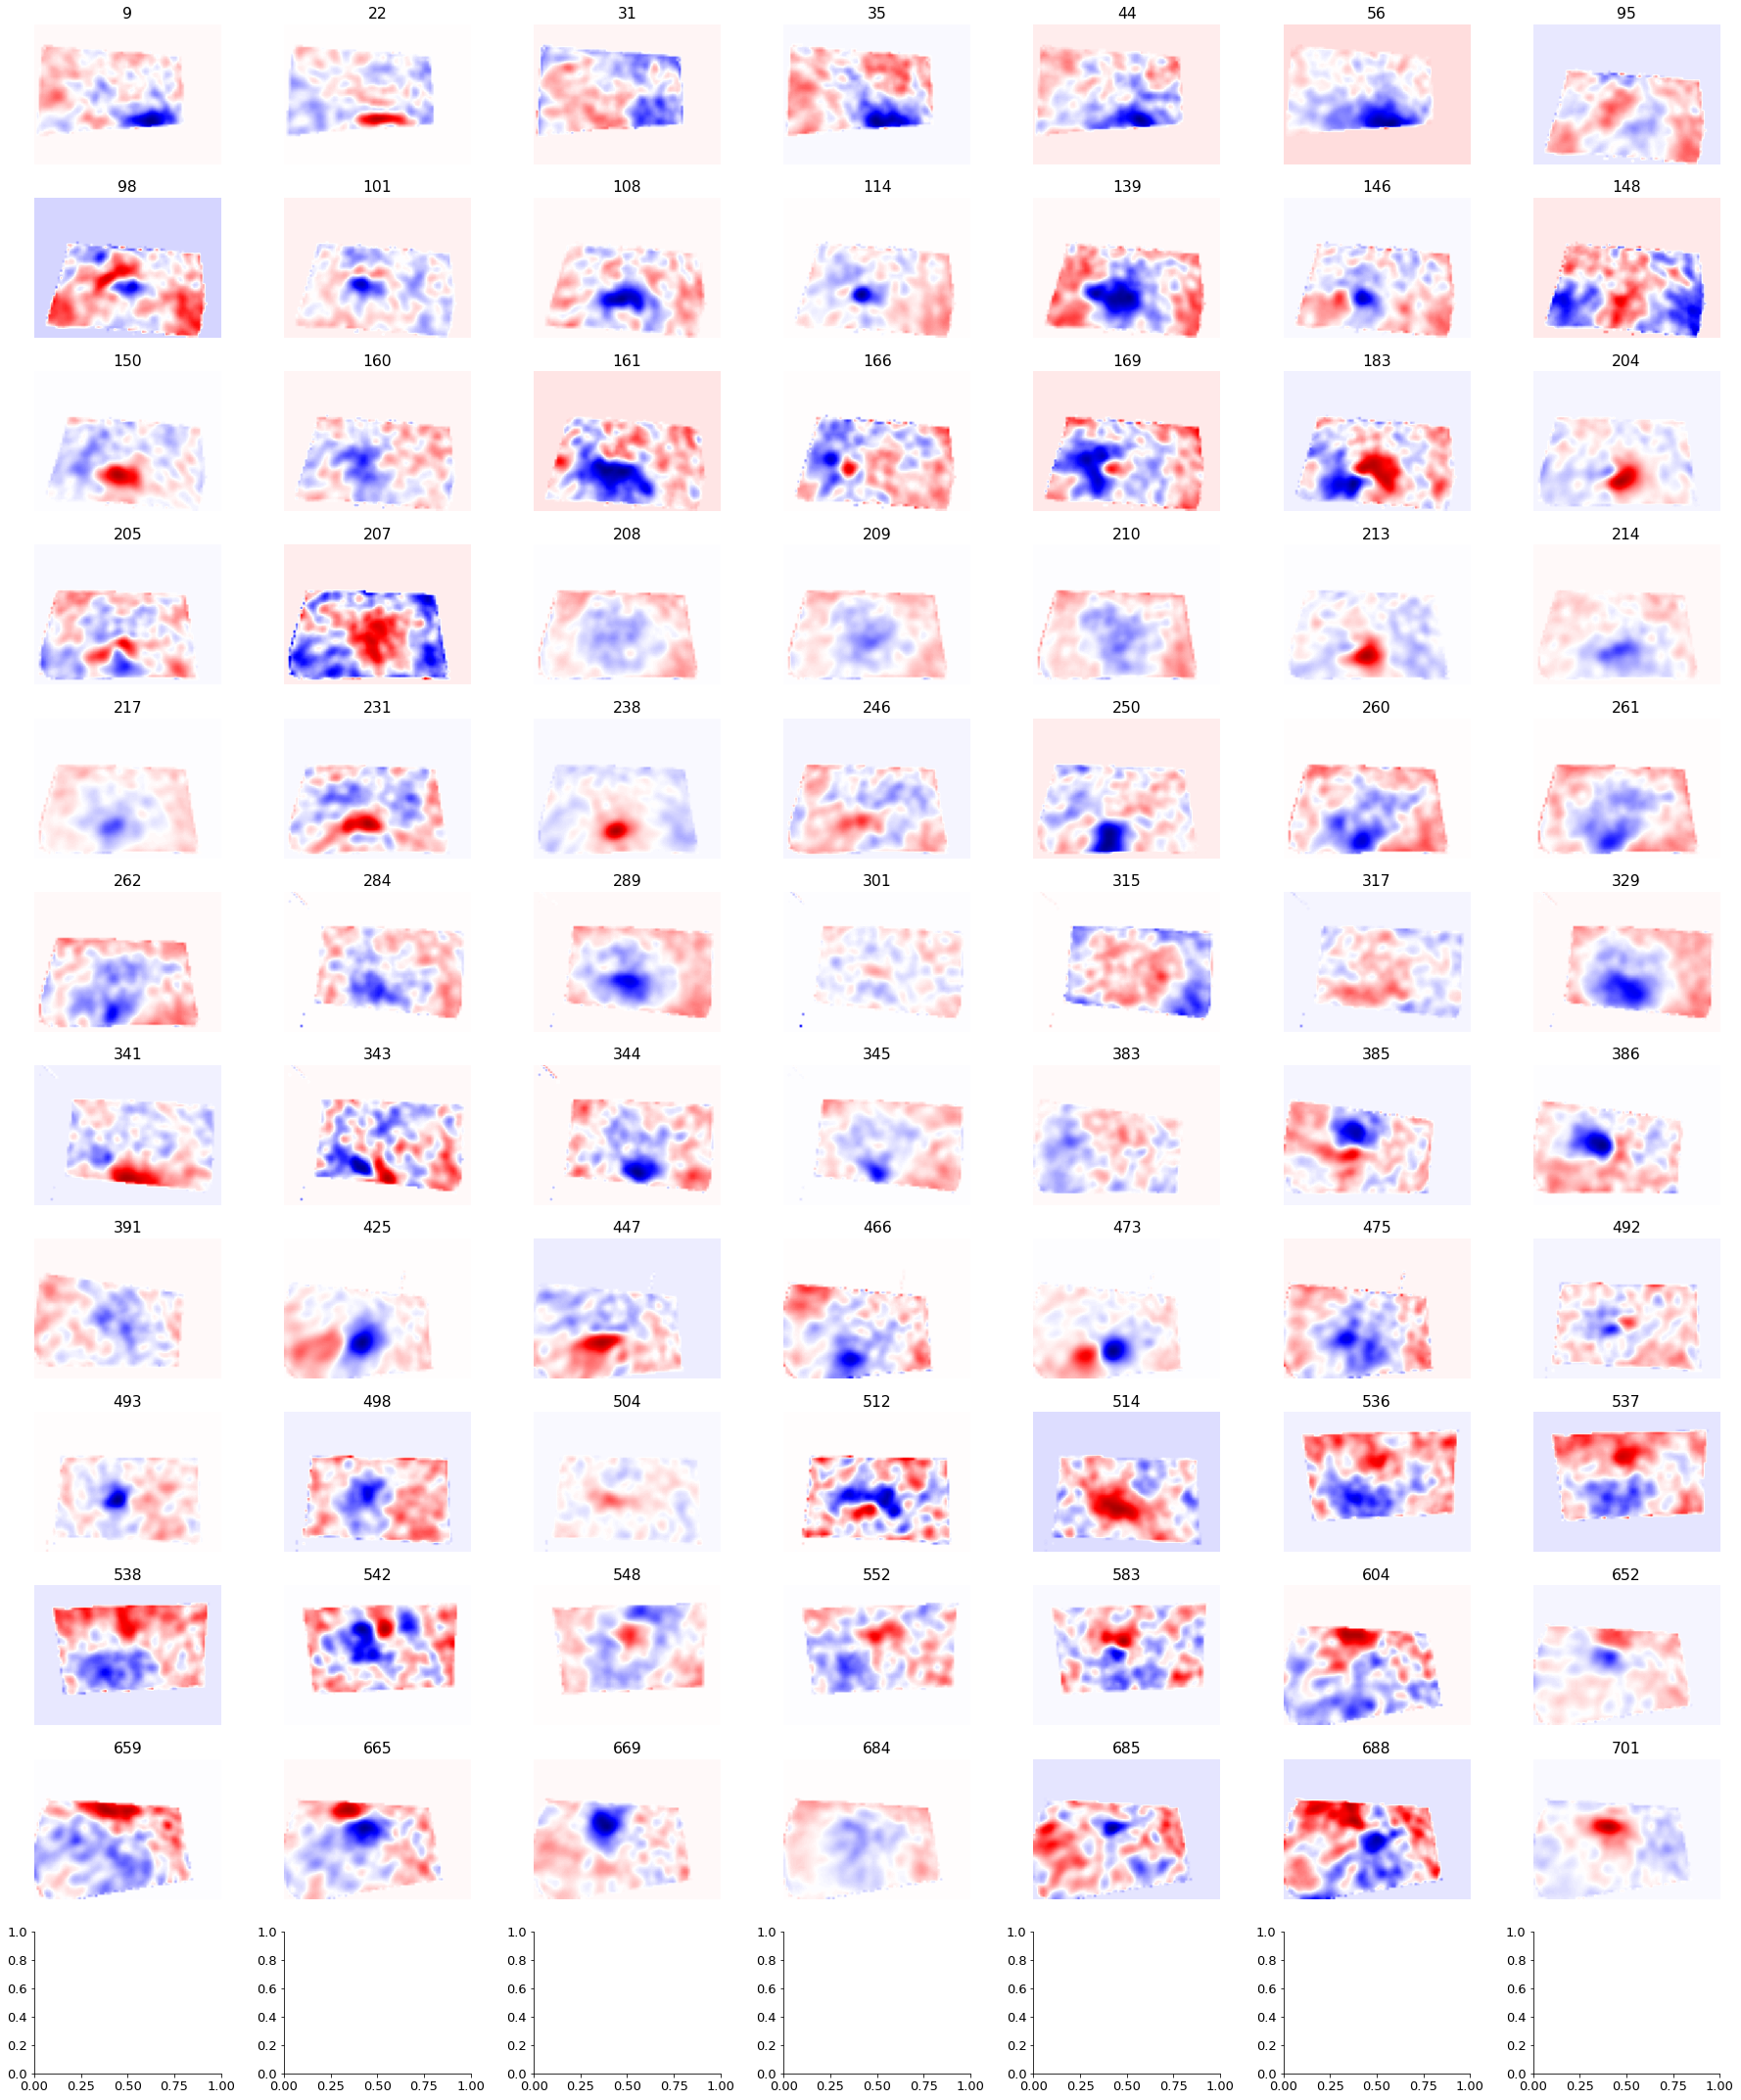

In [52]:
inds = hffm.data[hffm.data['movcluster1']=='late'][hffm.data['has_rf']==True].index.values
cdim = 12
dim = int(np.ceil(len(inds)/cdim))
plt.subplots(cdim,dim,figsize=(25,30))
for i, ind in enumerate(inds):
    plt.subplot(cdim,dim,i+1)
    sta = hffm.data.loc[ind,'Wn_spike_triggered_average']
    sta_range = np.max(np.abs(sta))*1.2
    sta_range = (0.25 if sta_range<0.25 else sta_range)
    plt.imshow(sta, vmin=-sta_range, vmax=sta_range, cmap='seismic')
    plt.axis('off'); plt.title(ind)
plt.tight_layout()

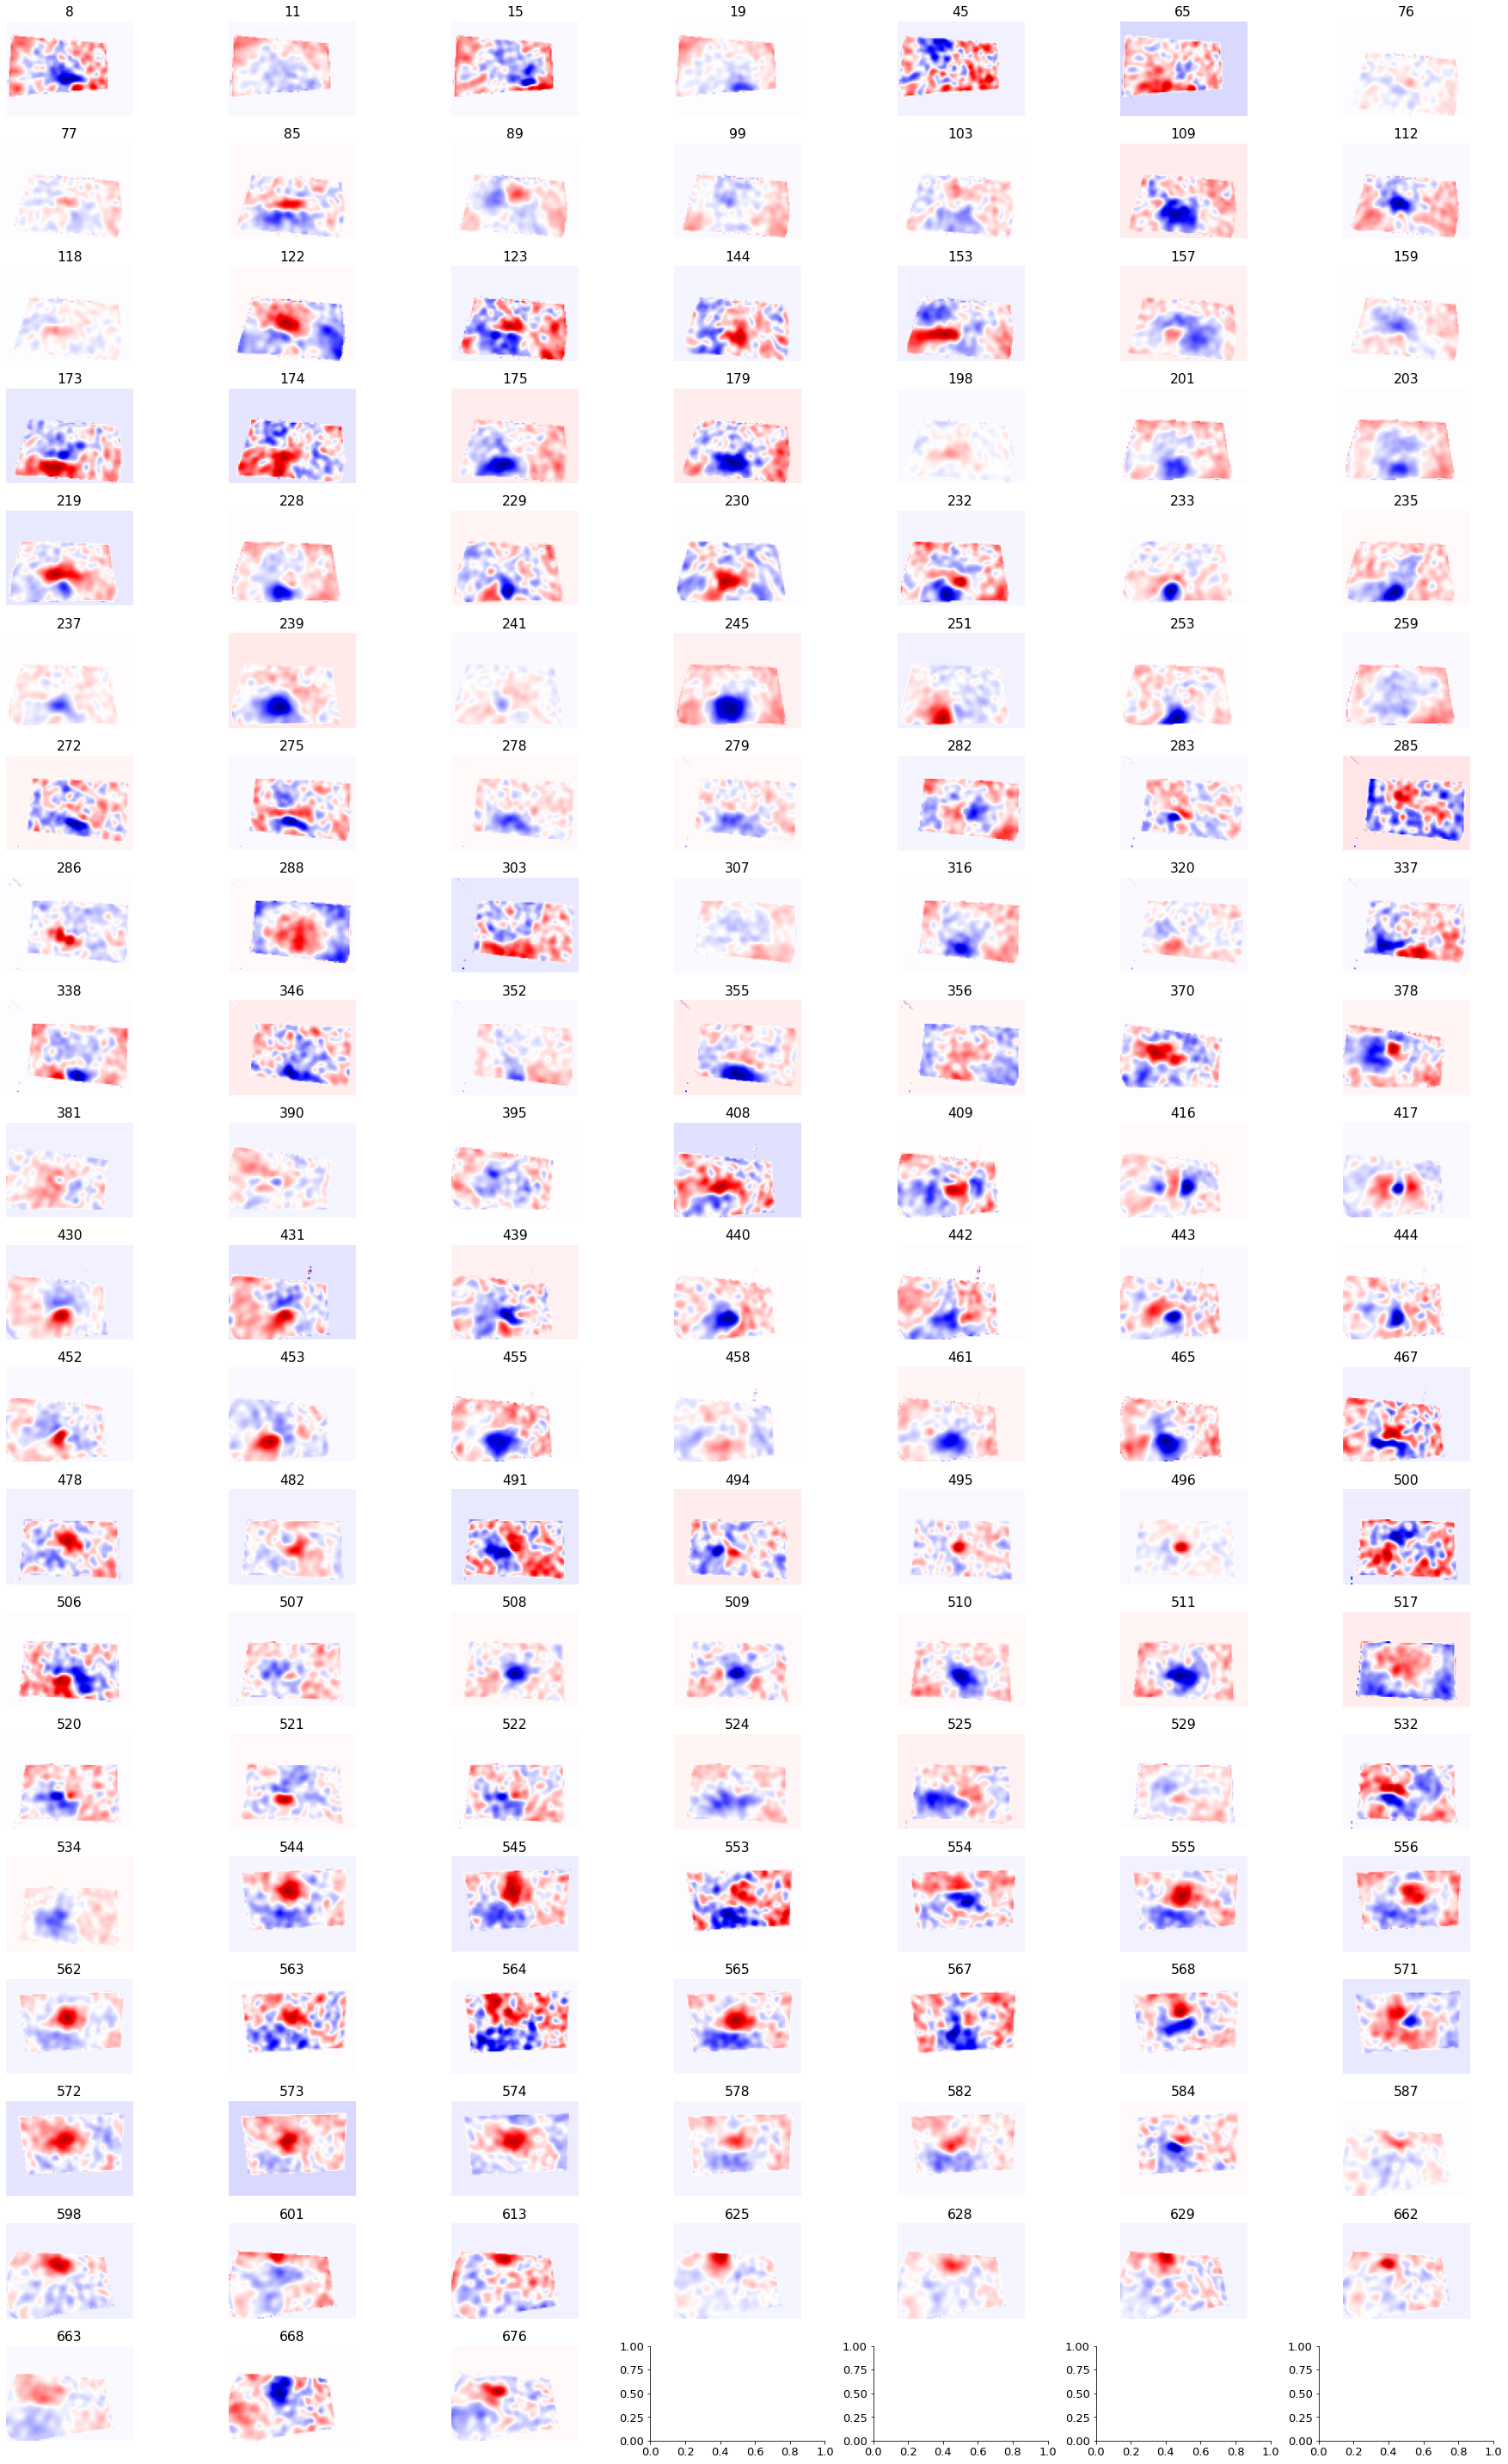

In [53]:
inds = hffm.data[hffm.data['movcluster1']=='biphasic'][hffm.data['has_rf']==True].index.values
cdim = 20
dim = int(np.ceil(len(inds)/cdim))
plt.subplots(cdim,dim,figsize=(25,40))
for i, ind in enumerate(inds):
    plt.subplot(cdim,dim,i+1)
    sta = hffm.data.loc[ind,'Wn_spike_triggered_average']
    sta_range = np.max(np.abs(sta))*1.2
    sta_range = (0.25 if sta_range<0.25 else sta_range)
    plt.imshow(sta, vmin=-sta_range, vmax=sta_range, cmap='seismic')
    plt.axis('off'); plt.title(ind)
plt.tight_layout()

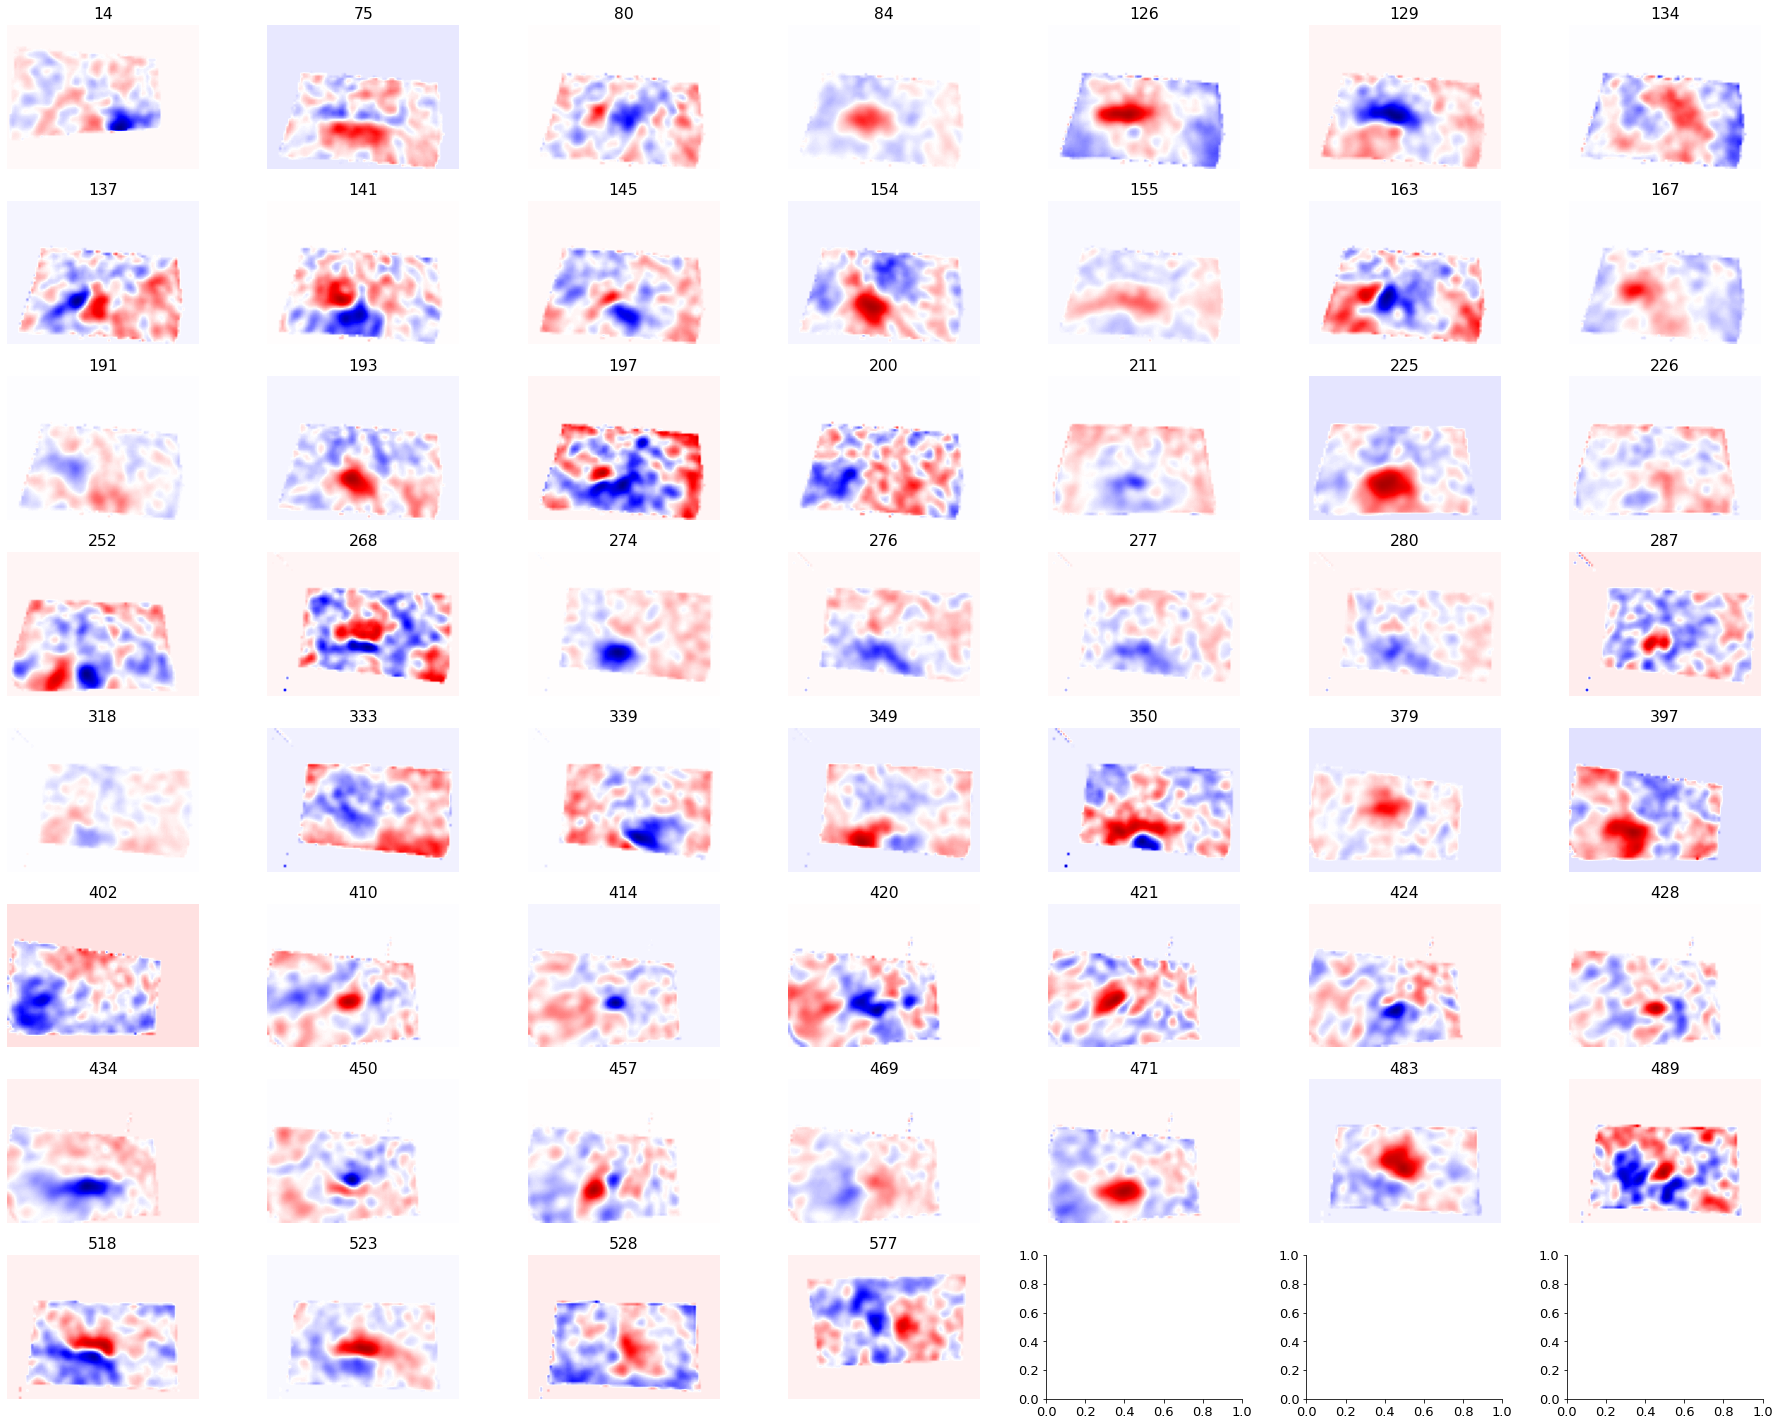

In [54]:
inds = hffm.data[hffm.data['movcluster1']=='negative'][hffm.data['has_rf']==True].index.values
cdim = 8
dim = int(np.ceil(len(inds)/cdim))
plt.subplots(cdim,dim,figsize=(25,20))
for i, ind in enumerate(inds):
    plt.subplot(cdim,dim,i+1)
    sta = hffm.data.loc[ind,'Wn_spike_triggered_average']
    sta_range = np.max(np.abs(sta))*1.2
    sta_range = (0.25 if sta_range<0.25 else sta_range)
    plt.imshow(sta, vmin=-sta_range, vmax=sta_range, cmap='seismic')
    plt.axis('off'); plt.title(ind)
plt.tight_layout()

In [39]:
mov_stas = [394,374,319,188,162,136,124,93,91,88] # movement
early_stas = [664,653,654,630,626,623,581,519,515,513,413,380,375,367,336,331,314,313,248,240,215,185,178,151,147,143,142,140,102,100,29,27,18] # early
late_stas = [9,31,22,31,35,44,56,95,98,101,108,114,139,146,148,204,183,169,166,161,160,150,205,207,213,214,217,231,208,209,210,289,284,262,261,260,250,246,238,301,315,317,329,341,343,344,345,425,391,386,385,383,447,466,473,475,492,493,498,548,542,538,537,536,514,512,504,552,583,604,669,665,659,652,684,685,688,701]
biphasic_stas = [8,11,15,19,45,85,77,76,65,89,99,103,109,112,118,122,174,173,159,157,153,144,123,175,179,198,201,203,219,239,237,235,233,232,230,229,228,241,245,251,253,259,286,285,283,282,279,278,275,272,288,303,307,316,355,352,346,338,337,320,356,370,378,381,390,409,408,395,416,417,430,431,439,440,442,465,461,458,455,453,452,444,443,467,478,482,491,510,509,508,507,506,500,496,495,494,511,517,520,521,522,524,525,529,556,555,554,553,545,544,534,532,562,563,564,565,567,568,578,574,573,572,571,582,584,587,628,625,613,601,598,629,662,663,668,676]
negative_stas = [14,75,80,84,137,134,129,126,141,145,154,155,163,167,191,252,226,225,211,200,197,193,268,274,276,277,280,287,226,252,333,318,287280,277,276,274,268,339,349,350,379,397,434,428,424,421,420,414,410,402,450,457,469,471,523,518,489,483,528,577]

In [43]:
has_stas = sorted(mov_stas + early_stas + late_stas + biphasic_stas + negative_stas)

In [45]:
hffm.data['has_rf'] = False
for i in has_stas:
    hffm.data.at[i, 'has_rf'] = True

(0.0, 1.0)

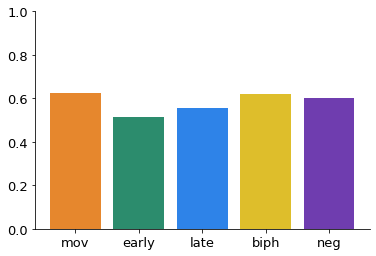

In [64]:
for i, c in enumerate(['movement','early','late','biphasic','negative']):
    cluster = hffm.data[hffm.data['movcluster1']==c]
    rfclust = cluster['has_rf'].value_counts()
    plt.bar(i, rfclust/len(cluster.index.values), color=hffm.cmap_movclusts[c])
plt.xticks(range(5), ['mov','early','late','biph','neg'])
plt.ylim([0,1])